# Code for the generation and analysis of the networks in "Analyzing bacterial networks and interations in skin and gills of *Sparus Aurata* with microalgae-based additive feeding"

The code here presented produces the networks and computes the ZiPi plot. For that it uses other results from radatools for the community structure that are available in the repository. In the first cell please decide if you want the code to work for gills or skin in the variable ``tissue`` 

In [30]:
# Packages needed
import networkx as nx
import pandas as pd
from scipy.stats import spearmanr
import numpy as np
import matplotlib.pyplot as plt

# this cvariable can take the values 'gills' and 'skin'
tissue = 'skin' 

## Create individual tables for each treatment

In [ ]:
# load initial table (change for "../data/skin_total.csv" for the skin data)
gills =  pd.read_csv("../data/"+tissue+"_total.csv", index_col=0)

taxa = ['Genus','Family', 'Order','Class','Phylum','Kingdom']
names = []
for index,row in gills.iterrows():
    aux = 0
    i = 0
    while aux == 0:
        if row[taxa[i]] != 'NA':
            aux = 1
        else:
            i+=1
    if i == 0:
        if len(row[taxa[i]].split()) == 1:
            names.append(index+'_'+row[taxa[i]])
        else:
            name_new = '_'.join(row[taxa[i]].split())
            names.append(index+'_'+name_new)
    else:
        if len(row[taxa[i]].split()) == 1:
            names.append(index+'_'+row[taxa[i]]+'_unclassified')
        else:
            name_new = '_'.join(row[taxa[i]].split())
            # print(name_new)
            names.append(index+'_'+name_new+'_unclassified')
gills['Names'] = names
# gills = gills.set_index('Names')

gills = gills.replace(gills.replace("NA", ""))

### Cargar las tablas y unirlas
gills_c =  pd.read_csv("../results/asv_"+tissue+"_CONTROL_1_2+1.csv", index_col=0, header=None)
gills_c = gills_c.merge(gills['Names'],left_index=True,right_index=True)
gills_c = gills_c.set_index('Names')

gills_r =  pd.read_csv("../results/asv_"+tissue+"_CRUDA_1_2+1.csv", index_col=0, header=None)
gills_r = gills_r.merge(gills['Names'],left_index=True,right_index=True)
gills_r = gills_r.set_index('Names')

gills_h =  pd.read_csv("../../codigo_original/asv_"+tissue+"_HIDRO_1_2+1.csv", index_col=0, header=None)
gills_h = gills_h.merge(gills['Names'],left_index=True,right_index=True)
gills_h = gills_h.set_index('Names')



S_H4                                               79.824276
S_H3                                                79.14806
S_R6                                               85.940577
S_R5                                               76.928682
S_H1                                               63.245116
S_H2                                               63.242322
S_H5                                               80.627937
S_H6                                               65.147195
S_R2                                                78.39053
S_R1                                               84.848162
S_C1                                               76.404025
S_C2                                               67.510188
S_C3                                               80.047978
S_C4                                                80.88109
S_R3                                               75.978592
S_R4                                               80.346575
S_C5                    

## Compute correlations

In [32]:
# Compute Spearman correlation
corr_c, p_value_c = spearmanr(gills_c.transpose())
corr_r, p_value_r = spearmanr(gills_r.transpose())
corr_h, p_value_h = spearmanr(gills_h.transpose())

# Create a boolean mask that is true for those values where p < 0.01 and correlation > 0.06.
# Apply the mask to the correlation matrix and replace missing (removed) values with 0, so that they are not included in the network.
corr_c = np.where((p_value_c < 0.01) & (np.abs(corr_c) > 0.6), corr_c, 0 )
corr_r = np.where((p_value_r < 0.01) & (np.abs(corr_r) > 0.6), corr_r, 0 )
corr_h = np.where((p_value_h < 0.01) & (np.abs(corr_h) > 0.6), corr_h, 0 )

# in case we want to remove the loops in the network that are created by correlation values of 1:
for i in range(corr_c.shape[0]):  
    corr_c[i,i] = 0.0
for i in range(corr_r.shape[0]):  
    corr_r[i,i] = 0.0
for i in range(corr_h.shape[0]):  
    corr_h[i,i] = 0.0
print(corr_r.shape[0])

177


## Create individual networks

In [33]:
# Create a list of node pairs and weights. Since filtered_corr is a numpy.array, it needs to be converted to an nx file (NetworkX).
G_C = nx.from_numpy_array(corr_c)
G_R = nx.from_numpy_array(corr_r)
G_H = nx.from_numpy_array(corr_h)

# Create an empty dictionary and add the names of the ASVs (Amplicon Sequence Variants).
mapping_c = {}
i=0
for c in gills_c.transpose().columns:
    mapping_c[i] = c
    i+=1

    
mapping_r = {}
i=0
for c in gills_r.transpose().columns:
    mapping_r[i] = c
    i+=1

mapping_h = {}
i=0
for c in gills_h.transpose().columns:
    mapping_h[i] = c
    i+=1

    
    
    
# Rename the nodes with the names from the previous dictionary (mapping).
G_C = nx.relabel_nodes(G_C, mapping_c, copy=True)
G_R = nx.relabel_nodes(G_R, mapping_r, copy=True)
G_H = nx.relabel_nodes(G_H, mapping_h, copy=True)

nx.write_pajek(G_C, "../results/"+tissue[0].upper()+"_C.net")
nx.write_pajek(G_R, "../results/"+tissue[0].upper()+"_R.net")
nx.write_pajek(G_H, "../results/"+tissue[0].upper()+"_H.net")

print(G_C.number_of_nodes())

180


## ZiPi plot

In [34]:
# for skin change here the file to '../results/communities_C_skin.txt'
# fin = open('../results/communities_C_'+tissue+'.txt','r')
fin = open('../results/communities_c_'+tissue+'.txt','r')
i = 0
comm_c = []
for line in fin:
    if i > 6:
        line = line.split(':')
        comm_c.append([int(a) for a in line[1].split()])
    i += 1
fin.close()

# for skin change here the file to '../results/communities_R_skin.txt'
# fin = open('../results/communities_R_'+tissue+'.txt','r')
fin = open('../results/communities_r_'+tissue+'.txt','r')
i = 0
comm_r = []
for line in fin:
    if i > 6:
        line = line.split(':')
        comm_r.append([int(a) for a in line[1].split()])
    i += 1
fin.close()

# for skin change here the file to '../results/communities_H_skin.txt'
# fin = open('../results/communities_H_'+tissue+'.txt','r')
fin = open('../results/communities_h_'+tissue+'.txt','r')
i = 0
comm_h = []
for line in fin:
    if i > 6:
        line = line.split(':')
        comm_h.append([int(a) for a in line[1].split()])
    i += 1
fin.close()

#  Define a dictionary to store the sequence names and their associated numbers.
# Control
dicc_c = {}
with open('../results/'+tissue[0].upper()+'_C.net', 'r') as file:
    for i,linea in enumerate(file):
        if i >= 1:
            temp = linea.strip().split(" ")
            try:
                num = int(temp[0])
                name = temp[1]
            except:
                print(temp)
            if temp[0] == "*edges":
                break
            dicc_c[num] = name

# Raw
dicc_r = {}
with open('../results/'+tissue[0].upper()+'_R.net', 'r') as file:
    for i,linea in enumerate(file):
        if i >= 1:
            temp = linea.strip().split(" ")
            try:
                num = int(temp[0])
                name = temp[1]
            except:
                print(temp)
            if temp[0] == "*edges":
                break
            dicc_r[num] = name

# Hidrolized
dicc_h = {}
with open('../results/'+tissue[0].upper()+'_H.net', 'r') as file:
    for i,linea in enumerate(file):
        if i >= 1:
            temp = linea.strip().split(" ")
            try:
                num = int(temp[0])
                name = temp[1]
            except:
                print(temp)
            if temp[0] == "*edges":
                break
            dicc_h[num] = name

print(comm_c)

# Create a new list of communities with the correct name.
new_c = []
for comm in comm_c:
    new_c.append([dicc_c[x] for x in comm])


new_r = []
for comm in comm_r:
    new_r.append([dicc_r[x] for x in comm])
    

new_h = []
for comm in comm_h:
    new_h.append([dicc_h[x] for x in comm])


['*edges']
['*edges']
['*edges']
[[2, 5, 17, 29, 47, 59, 64, 82, 83, 87, 91, 99, 102, 112, 120, 125, 126, 130, 143, 144, 148, 150, 154, 156, 166, 173, 176, 178], [9, 24, 27, 48, 49, 54, 61, 68, 79, 93, 95, 96, 108, 114, 119, 123, 132, 133, 140, 142, 164, 179], [3, 6, 7, 11, 20, 31, 73, 76, 84, 85, 88, 111, 117, 118, 139, 149, 155, 159, 160, 165], [15, 16, 35, 36, 42, 65, 66, 77, 103, 110, 127, 131, 145, 151], [62, 89, 121, 136, 141, 161, 162, 163, 170, 177], [10, 55, 57, 75, 97, 115, 180], [1, 25, 41, 69, 71, 113], [21, 44, 45, 74, 90, 167], [23, 43, 51, 63, 78], [4, 52, 80, 116, 169], [19, 53, 92, 106, 107], [30, 34, 175], [13, 37, 134], [60, 109, 137], [38, 104], [22, 58], [40, 70], [14, 98], [81, 128], [122, 129], [28, 135], [138, 153], [101, 168], [147, 171], [8], [12], [18], [26], [32], [33], [39], [46], [50], [56], [67], [72], [86], [94], [100], [105], [124], [146], [152], [157], [158], [172], [174]]


Metrics for the comparison of communities by pairs. Both compute the jaccard index of each pair of communities.

In [35]:
def compare_partitions(part_1,part_2):
    '''
    computes the matrix that compares communities using the jaccard index
    '''
    N1 = len(part_1)
    N2 = len(part_2)
    comparison = np.zeros((N1,N2))
    for i in range(N1):
        for j in range(N2):
            comparison[i,j] = len(set(part_1[i]).intersection(set(part_2[j])))/len(set(part_1[i]).union(set(part_2[j])))
    return comparison


def compare_partitions_restricted(part_1,part_2,G_1,G_2):
    '''
    computes the matrix that compares communities using the jaccard index but only for the nodes that are common to both networks
    '''
    set_1 = set(G_1.nodes)
    set_2 = set(G_2.nodes)
    set_int = set_1.intersection(set_2)
    N1 = len(part_1)
    N2 = len(part_2)
    comparison = np.zeros((N1,N2))
    for i in range(N1):
        for j in range(N2):
            tot = len(set(part_1[i]).intersection(set_int).union(set(part_2[j]).intersection(set_int)))
            if tot != 0:
                comparison[i,j] = len(set(part_1[i]).intersection(set_int).intersection(set(part_2[j]).intersection(set_int)))/tot
    return comparison

### Define functions to compute Zi and Pi values

The within-module degree (Zi) and between-module connectivity with respect to the entire network (Pi) must be calculated.

In [36]:
def assign_communities(G,communities):
    '''
    Assigns community label to a property of the node called 'Comun'
    Input:
    -G: nx.Graph
    -communities: list of lists with node members of the communities
    Output:
    None
    '''
    i = 0
    for c in communities:
        for node in c:
            if node in G.nodes:
                G.nodes[node]['Comun'] = i
            else:
                print(node)
        i += 1
    nodes = list(G.nodes())
    for node in nodes:
        if 'Comun' not in G.nodes[node].keys():
            G.remove_node(node)
    return None

def calculate_degree_to_communities(G):
    '''
    calculates the degree of each node to each community and saves it in a dictionary as a property of the node called kc
    '''
    modules = get_modules(G)
    for node in G.nodes:
        kc_dict = dict(zip(modules,[0]*len(modules)))
        for neigh in G.neighbors(node):
            kc_dict[G.nodes[neigh]['Comun']] += 1
        G.nodes[node]['kc'] = kc_dict
    return

def get_modules(G):
    '''
    gives the set of modules
    '''
    modules = set([G.nodes[node]['Comun'] for node in G.nodes])
    return modules

def calculate_Zi(G):
    '''
    computes zi
    '''
    modules = get_modules(G)
    for module in modules:
        nodes = [node for node in G.nodes() if G.nodes[node]['Comun']==module]
        degs = np.array([G.nodes[node]['kc'][module] for node in G.nodes if G.nodes[node]['Comun']==module])
        k_mean = np.mean(degs)
        k_std = np.std(degs)
        if k_std != 0:
            zis = (degs-k_mean)/k_std
        else:
            zis = np.array([0]*len(degs))
        for i in range(len(nodes)):
            G.nodes[nodes[i]]['Zi'] = zis[i]
    return

def calculate_Pi(G):
    '''
    Calculates Pi
    '''
    modules = get_modules(G)
    for node in G.nodes:
        Pi = 0
        k_i = G.degree(node)
        if k_i > 0:
            Pi = 1
            for module in modules:
                Pi -= np.power(G.nodes[node]['kc'][module]/k_i,2)
        G.nodes[node]['Pi'] = Pi           
    return

def get_Zi_Pi(G,communities):
    '''
    Gives Zi and Pi for a network and a partition
    '''
    assign_communities(G,communities)
    calculate_degree_to_communities(G)
    calculate_Zi(G)
    calculate_Pi(G)
    Zi = [G.nodes[node]['Zi'] for node in G.nodes]
    Pi = [G.nodes[node]['Pi'] for node in G.nodes]
    return Zi,Pi

### ZiPi plot

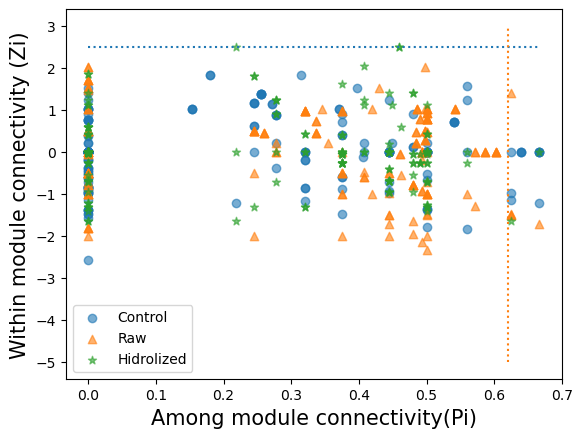

In [37]:
#Modularidad radtools
Zi_C,Pi_C = get_Zi_Pi(G_C,new_c)
plt.scatter(Pi_C, Zi_C,label='Control', alpha=0.6)

Zi_R,Pi_R = get_Zi_Pi(G_R,new_r)
plt.scatter(Pi_R,Zi_R,label='Raw', alpha=0.6,marker='^')

Zi_H,Pi_H = get_Zi_Pi(G_H,new_h)
plt.scatter(Pi_H,Zi_H,label='Hidrolized', alpha=0.6, marker='*')

x_line_y = [min(Pi_C + Pi_R + Pi_H), max(Pi_C + Pi_R + Pi_H)]
y_line_y = [2.5, 2.5]
plt.plot(x_line_y, y_line_y, linestyle='dotted')

x_line_x = [0.62, 0.62]
y_line_x = [-5, 3]
plt.plot(x_line_x, y_line_x, linestyle='dotted')

plt.ylabel('Within module connectivity (Zi)', fontsize=15)
plt.xlabel('Among module connectivity(Pi)', fontsize=15)
plt.legend(loc=3)


# change output to '../figures/ZiPi_gills.png'
plt.savefig('../figures/ZiPi_'+tissue+'.png', dpi=199)
